<a href="https://colab.research.google.com/github/upayuryeva/Deep-Learning-course-HSE-/blob/main/week4/homework4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [ ]:
import requests

# class labels
LABELS_URL = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
labels = {i: c for i, c in enumerate(requests.get(LABELS_URL).json())}

In [ ]:
print(list(labels.items())[:5])

[(0, 'tench'), (1, 'goldfish'), (2, 'great white shark'), (3, 'tiger shark'), (4, 'hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [ ]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor([[-1.3141,  0.9231,  1.4841,  ..., -1.9805, -0.3632,  1.5443],
        [-1.0908,  1.0080,  2.2941,  ..., -2.2051, -0.6893,  1.6879],
        [-1.1056,  1.0960,  2.0870,  ..., -2.0698, -0.5420,  1.3410],
        [-1.2946,  0.7009,  2.0010,  ..., -2.0877, -0.5919,  1.2695],
        [-1.4746,  0.6489,  1.5891,  ..., -1.9103, -0.5834,  1.3203]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

In [ ]:
# If using Colab
!mkdir sample_images
!wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

mkdir: cannot create directory ‘sample_images’: File exists
--2021-10-18 16:56:51--  https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11607 (11K) [image/jpeg]
Saving to: ‘sample_images/albatross.jpg’

sample_images/albat 100%[===================>]  11.33K  --.-KB/s    in 0s      

2021-10-18 16:56:51 (35.5 MB/s) - ‘sample_images/albatross.jpg’ saved [11607/11607]



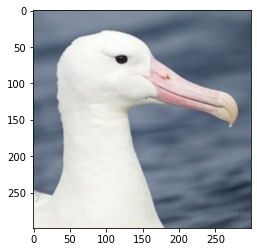

top-10 classes are: 
 [prob : class label]
0.9745 :	albatross
0.0030 :	turnstile
0.0005 :	Shetland Sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	duck
0.0003 :	hammerhead shark
0.0003 :	nipple
0.0003 :	Polaroid camera


In [ ]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [ ]:
!wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

--2021-10-18 16:56:52--  http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Resolving cdn.com.do (cdn.com.do)... 104.26.8.119, 104.26.9.119, 172.67.68.26, ...
Connecting to cdn.com.do (cdn.com.do)|104.26.8.119|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg [following]
--2021-10-18 16:56:52--  https://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg
Connecting to cdn.com.do (cdn.com.do)|104.26.8.119|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51048 (50K) [image/jpeg]
Saving to: ‘img.jpg’

img.jpg             100%[===================>]  49.85K  --.-KB/s    in 0.01s   

2021-10-18 16:56:52 (4.45 MB/s) - ‘img.jpg’ saved [51048/51048]



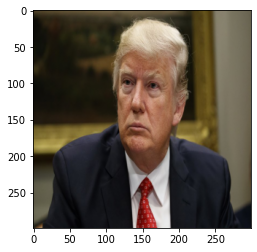

top-10 classes are: 
 [prob : class label]
0.6924 :	suit
0.0912 :	Windsor tie
0.0627 :	bridegroom
0.0045 :	oboe
0.0040 :	academic gown
0.0034 :	slip-on shoe
0.0032 :	wig
0.0028 :	Afghan Hound
0.0027 :	bow tie


In [ ]:
img = resize(plt.imread('img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [ ]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
# if the link does not work, you can download the dataset manually from https://disk.yandex.ru/d/nuyCNaDrE1Bq0w
!unzip -n data.zip

File ‘data.zip’ already there; not retrieving.
Archive:  data.zip


### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [ ]:
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [ ]:
#extract features from images
from tqdm import tqdm
from imageio import imread
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 32
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0
embedding = embedding.to('cuda')

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32)
        
        with torch.no_grad():
          # use your embedding model to produce feature vector
          features = embedding(input_tensor.to('cuda'))
        
          X.append(features)
        
        batch_index = 0
        continue
        
    batch_index += 1

100%|██████████| 25000/25000 [04:04<00:00, 102.31it/s]


In [ ]:
X = torch.cat(X).cpu().data.numpy()  #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(24992, 2048) (24992,)


In [ ]:
<split data here or use cross-validation>

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

X_train, X_tv, y_train, y_tv = train_test_split(X, Y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test =train_test_split(X_tv, y_tv, test_size=0.1, random_state=42)

clf = RidgeCV()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9472368795667594

# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

### Dataloaders

In [ ]:
# was interested to play with ImageFolder class cause all of the data was in a same directory, 
# so classic ImageFolder could not process it, cause it needs to have all classes in different folders
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
import os
import glob

class FileImageFolder(datasets.ImageFolder):
  def __init__(self, root, transform=None, train=None):
      super(FileImageFolder, self).__init__(root,
                                        transform=transform)
      self.train = train
      self.samples = self.split(self.samples, self.train)
  
  def split(self, samples, train, test_size=0.2, rs=42):
      if train == None:
          return samples
      train_set, test_set = train_test_split(samples, test_size=test_size, random_state=rs)
      
      if train==True:
          return train_set
      else:
          return test_set

  def find_classes(self, directory):

      directory = os.path.expanduser(directory)
    
      classes = {os.path.basename(filename).split('.')[0] for filename in glob.glob(directory + '/*')}  
      if not classes:
        raise FileNotFoundError(f"Couldn't find any class files in {directory}.")
      class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
      return classes, class_to_idx

  def make_dataset(self, directory, *args):

    directory = os.path.expanduser(directory)
    all_paths = glob.glob(directory + '/*')
    instances = []
    _, class_to_idx = self.find_classes(directory)

    for target_class in sorted(class_to_idx.keys()):
        class_index = class_to_idx[target_class]
        target_dir = os.path.join(directory, target_class)
        for path in all_paths:
            if path.startswith(target_dir):
                item = path, class_index
                instances.append(item)
    return instances

In [ ]:
means = np.array([0.485, 0.456, 0.406])
stds = np.array([0.229, 0.224, 0.225])

input_size = 224


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ])
}

In [ ]:
data_path = '/content/train'

train_imgfolder = FileImageFolder(data_path, transform=data_transforms['train'], train=True)
test_imgfolder = FileImageFolder(data_path, transform=data_transforms['test'], train=False)

val_size = int(0.5 * len(test_imgfolder))
test_size = int(0.5 * len(test_imgfolder))
val_imgfolder, test_imgfolder = torch.utils.data.random_split(test_imgfolder, 
                                                          [val_size, test_size],
                                                          generator=torch.Generator().manual_seed(42))

In [ ]:
batch_size = 32

image_datasets = {'train':train_imgfolder,
                  'val':val_imgfolder,
                  'test':test_imgfolder}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                                   batch_size=batch_size, 
                                                   shuffle=True,
                                                   num_workers=2) 
                                                   for x in image_datasets.keys()}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


X: <class 'torch.Tensor'> torch.Size([32, 3, 224, 224])
y: <class 'torch.Tensor'> torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


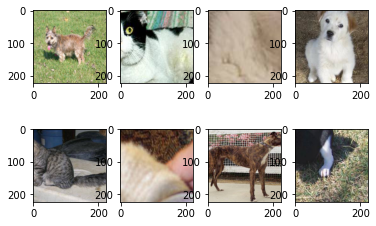

In [ ]:
for (x_batch, y_batch) in dataloaders_dict['train']:
    
    print('X:', type(x_batch), x_batch.shape)
    print('y:', type(y_batch), y_batch.shape)
    
    for i, img in enumerate(x_batch.numpy()[:8]):
        plt.subplot(2, 4, i+1)
        plt.imshow(img.transpose([1,2,0]) * stds + means )
    plt.show()
    break

### Functions for training models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# # Initialize the model for this run
# model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# # Print the model we just instantiated
# print(model_ft)

## Train and evaluate models

### Resnet

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
num_hidden = 128

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, num_hidden, feature_extract)

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 fc.weight
	 fc.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.1973 Acc: 0.9172
val Loss: 0.0738 Acc: 0.9720

Epoch 1/14
----------
train Loss: 0.1645 Acc: 0.9282
val Loss: 0.0602 Acc: 0.9784

Epoch 2/14
----------
train Loss: 0.1569 Acc: 0.9310
val Loss: 0.0601 Acc: 0.9784

Epoch 3/14
----------
train Loss: 0.1580 Acc: 0.9316
val Loss: 0.0585 Acc: 0.9784

Epoch 4/14
----------


KeyboardInterrupt: ignored

In [ ]:
model_ft.eval()
test_batch_acc = []
with  torch.no_grad():
  for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    y_pred = outputs.max(1, keepdim=True)[1]
    test_batch_acc.append(y_pred.eq(labels.view_as(y_pred)).sum().item()/len(y_pred))

test_accuracy = np.mean(test_batch_acc)
print("Resnet test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

Resnet test accuracy:		98.54 %


### VGG

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
num_hidden = 128

# Number of epochs to train for
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [ ]:
model_ft, input_size = initialize_model(model_name, num_classes, num_hidden, feature_extract)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=0.001)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Epoch 0/14
----------
train Loss: 0.1672 Acc: 0.9271
val Loss: 0.0479 Acc: 0.9792

Epoch 1/14
----------
train Loss: 0.1649 Acc: 0.9314
val Loss: 0.0474 Acc: 0.9824

Epoch 2/14
----------
train Loss: 0.1817 Acc: 0.9255
val Loss: 0.0455 Acc: 0.9820

Epoch 3/14
----------
train Loss: 0.1765 Acc: 0.9273
val Loss: 0.0445 Acc: 0.9812

Epoch 4/14
----------
train Loss: 0.1679 Acc: 0.9344
val Loss: 0.0488 Acc: 0.9804

Epoch 5/14
----------


KeyboardInterrupt: ignored

In [ ]:
model_ft.eval()
test_batch_acc = []
with  torch.no_grad():
  for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model_ft(inputs)
    y_pred = outputs.max(1, keepdim=True)[1]
    test_batch_acc.append(y_pred.eq(labels.view_as(y_pred)).sum().item()/len(y_pred))

test_accuracy = np.mean(test_batch_acc)
print("VGG test accuracy:\t\t{:.2f} %".format(test_accuracy * 100))

VGG test accuracy:		98.77 %
